In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.colors import LogNorm
import fun.my_functions as mf

# Load data

In [2]:
data = np.load("../data/jica_datarequest_nr8.npz")
n_data = np.load("../data/jica_datarequest_nr11.npz")
vel_data = np.load("../data/jica_datarequest_nr7.npz")
sc_pot_data = np.load("../data/jica_datarequest_nr10.npz")

In [3]:
spec_p = data['p1'].flatten()
spec_n = n_data['n1'].flatten()
time_p = data['time']
velocity = vel_data['speed'] * 1e3
sc_pot = sc_pot_data['scpot']

# Remove background

1


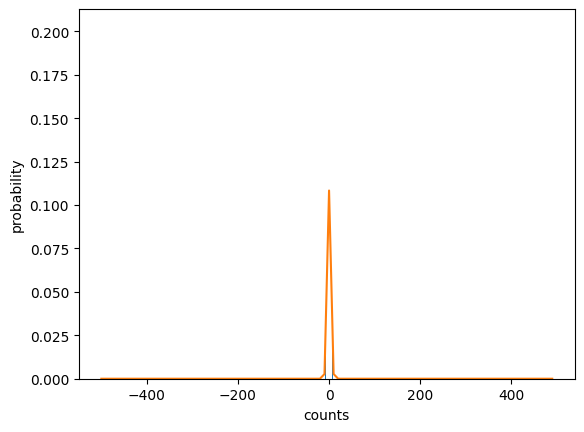

In [4]:
e_bins = np.arange(spec_p.shape[0])
spec_p_c = mf.red_j_spec_err(spec_p, [400, 512], [0, 1], savename='p1')
mass_p = mf.calc_mass(np.arange(len(spec_p_c)), sc_pot, velocity)
density_p = mf.calc_current(spec_p_c, 'p1')

/tmp/ipykernel_120567/2320688414.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


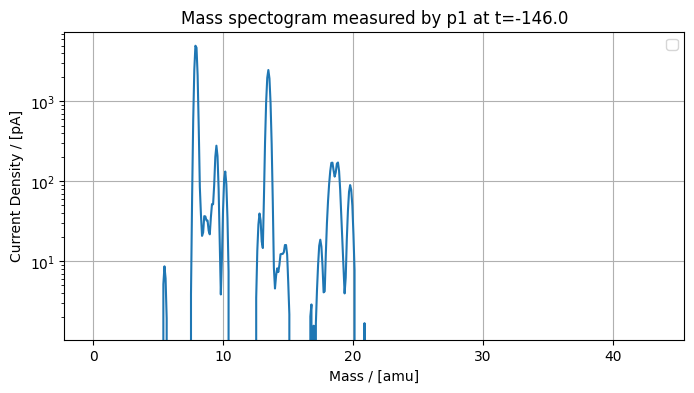

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))  # width=8 inches, height=4 inches

ax.plot(mass_p, density_p)

# Add labels and title
ax.set_xlabel('Mass / [amu]')
ax.set_ylabel('Current Density / [pA]')
ax.set_title(f'Mass spectogram measured by p1 at t={time_p[0]}')
ax.legend()
ax.set_yscale('log')
# Optional: grid
ax.grid(True)

# Show the figure
plt.show()

1


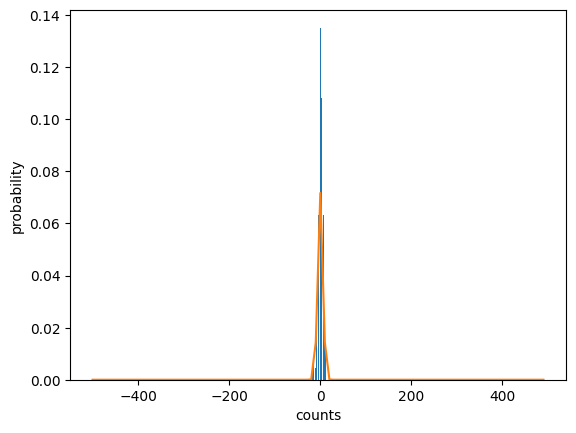

In [6]:
spec_n_c = mf.red_j_spec_err(spec_n, [400, 512], [0, 1], savename='n1')
mass_n = mf.calc_mass(np.arange(len(spec_n_c)), sc_pot, velocity)
density_n = mf.calc_current(spec_n_c, 'n1')

/tmp/ipykernel_120567/1253403146.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


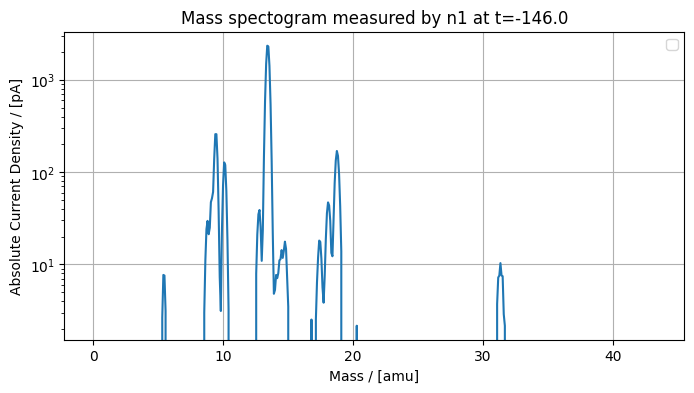

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))  # width=8 inches, height=4 inches

ax.plot(mass_n, -density_n)

# Add labels and title
ax.set_xlabel('Mass / [amu]')
ax.set_ylabel('Absolute Current Density / [pA]')
ax.set_title(f'Mass spectogram measured by n1 at t={time_p[0]}')
ax.legend()
ax.set_yscale('log')
# Optional: grid
ax.grid(True)

# Show the figure
plt.show()